# Building A Face Detector with Dlib
I came across dlib recently: a C++ library  of deep learning tools which, among other things, can be used for image detection. I wanted to check it out, so here are my experiences with compiling and using dlib to create a face detector.

## Compiling dlib
I haven't had to compile too many Python libraries so far, as most of the libraries I use can be pip installed. Dlib however, has excellent documentation which includes instructions for compiling on their [website](http://dlib.net/compile.html). It wasn't a smooth process though, here's what I had to do:

After cloning this [dlib directory](https://github.com/davisking/dlib) to my computer, I entered the following commands to build dlib.

In [ ]:
cd dlib/examples
mkdir build
cd build
cmake .. -DUSE_AVX_INSTRUCTIONS=1
cmake --build .

It took a few tries to get the last line to execute correctly. At around the 30% mark, I came across the error <font color="grey">"wchar.h file not found"</font> and found I had to update to the latest version of Xcode and macOS to solve the problem.

I also compiled imglab, which lets you markup your own set of training and test images. Changing the directory back to the dlib root folder, I entered the following commands:  

In [ ]:
cd tools/imglab
mkdir build
cd build
cmake ..
cmake --build . --config Release

While you can build an object detector using dlib directly, I wanted to also use Python, so I needed to compile dlib's Python API. I understand that you can pip install dlib from here, but I compiled it using the command below (having first installed boost-python). 

In [ ]:
python setup.py install --yes USE_AVX_INSTRUCTIONS

I came across multiple errors at this point, the first was in relation to the dlib.so file and libboost libraries not being loaded. The error was very similar to [this one](https://stackoverflow.com/questions/33281753/unsafe-use-of-relative-rpath-libboost-dylib-when-making-boost-python-helloword-d) and my fix involved using the otool command and changing the path for a number of .dylib files that were showing as incorrect (which meant finding the *actual* location of these files in order to correct them).  

Errors also included the <font color="grey">"use of undeclared identifier"</font> leading to <font color="grey">"too many errors emitted"</font>. With the help of my friend Google, I [found](https://github.com/davisking/dlib/issues/111) I had a broken version of X11 on my machine. Deleting the entire X11 folder in `/anaconda/include/X11`, forced cmake to use the system copy of X11 which completely fixed the problem.

And then finally, everything was fully installed!

## Generating training and test data sets
I wanted to create my own dataset rather than use dlib's included dataset, so I collected around 50 images of Chimpanzees from Google, divided 80:20 into the training and test sets. This is a small dataset, but I didn't want to spend the next week labelling images. 

Dlib's handy imglab tool helps with labelling. It generates an XML file, which contains a list of all the image file paths and the pixel location of all bounding boxes in each image. The file then serves as an input to dlib's train_simple_object_detector() function. The documentation gives clear instructions on how to use imglab (see the README.txt in dlib/tools/imglab). 

I saved all my training images in a folder called /Images/chimp-training-images. Opening Terminal and changing directory to the dlib root folder, I created an XML file called 'chimp_train.xml' using the following command:

In [ ]:
tools/imglab/build/imglab -c chimp_train.xml ../Images/chimp-training-images

The command takes the format:
> [path to imglab] -c [XML filename] [path to training images]

To add the red bounding boxes, I ran:

In [ ]:
tools/imglab/build/imglab chimp_train.xml

This opens the imglab tool, which looks something like:  

![imglab](Images/chimp.png "Figure 2: Marking up images with imglab")

Labelling is as simple as holding the shift key, left clicking and dragging the mouse to form a box around each face. Once all the images were labelled, I saved the file and closed the window.  

I did this for for both 'chimp_train.xml' and 'chimp_test.xml'. The XML files get created in the in the dlib root folder, so I moved them elsewhere once I was finished labelling. 

## Building a face detector
Using the example code, it takes mere minutes to train and test a simple object detector. Much of the code here has been repurposed from the [example python script](dlib.net/train_object_detector.py.html) on [dlib.net](dlib.net). 

In [1]:
# import libraries
import cv2 
import dlib
import numpy as np
import matplotlib.pyplot as plt 
import os
from PIL import Image
%matplotlib inline

The various options below are explained in more detail [here](dlib.net/train_object_detector.py.html), and I took advantage of the option to bootstrap my data, generating vertical flips and various rotations of each face in my dataset. I also played around with the SVM parameter, which affected the accuracy of the model on the test set.

In [2]:
# options for the dlib object detector training module
options = dlib.simple_object_detector_training_options()
options.num_threads = 4                      
options.be_verbose = True
options.add_left_right_image_flips = True
options.add_image_rotations = True 

# the SVM parameter
options.C = 100

In [3]:
# load training data and testing data paths
img_folder = 'Images/chimp-training-images'
training_xml_path = os.path.join(img_folder, 'chimps_train.xml')
testing_xml_path = os.path.join(img_folder, 'chimps_test.xml')

# perform the training
dlib.train_simple_object_detector(training_xml_path, 'detector.svm', options)
print 'detector training done with option.C = ' + str(options.C) + '!'

# print training and testing accuracy, precision, etc,
print('')  # Print blank line to create gap from previous output
print('Testing accuracy: {}'.format(
    dlib.test_simple_object_detector(training_xml_path, 'detector.svm')))

print('Testing accuracy: {}'.format(
    dlib.test_simple_object_detector(testing_xml_path, 'detector.svm')))

detector training done with option.C = 100.0!

Training accuracy: precision: 1, recall: 1, average precision: 1
Testing accuracy: precision: 1, recall: 0.888889, average precision: 0.888889


This is a Histogram of Oriented Gradients (HOG) based object detector, so let's have a look at the HOG filter the object detector learned from the training data.

In [4]:
# load your newly trained face detector
detector = dlib.simple_object_detector('detector.svm')

# We can look at the HOG filter we learned. 
win_det = dlib.image_window()
win_det.set_image(detector)

<img src = "Images/HOG_filter.png", width = 200, height = 400>

Does it look like a chimpanzee's face? You can definitely see where the eyes and mouth are, as well as the general shape around the face. 

Let's see how the object detector performs on a test image. Thanks [Jeremy Watt](https://github.com/jermwatt/udacity_mlnd_lab_face_detection/blob/master/face_detection_demo.ipynb) for the code to print these images to jupyter notebook.

Face detection done!  Plotting results.


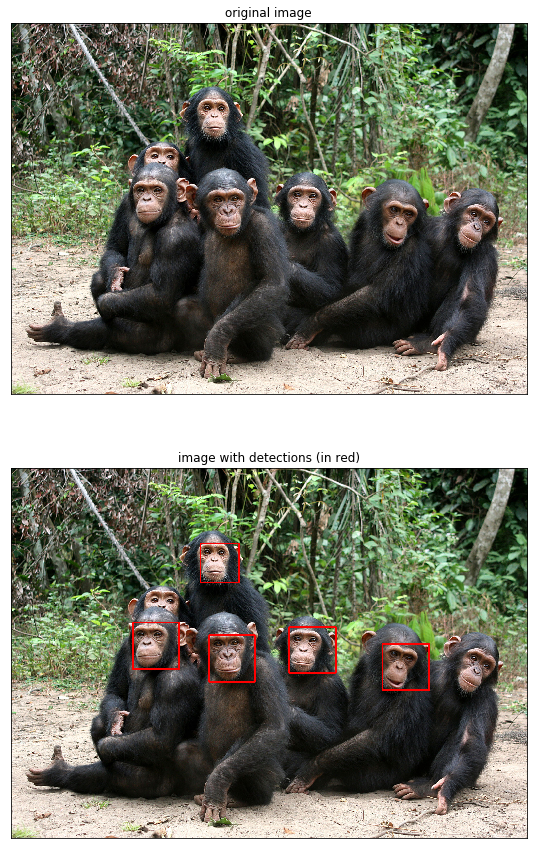

In [5]:
# make a copy of the original image (for plotting purposes) 
test_img = Image.open('test.jpg')
img = test_img.copy()
img = np.array(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# load your newly trained face detector
detector = dlib.simple_object_detector('detector.svm')

# Run the face detector, upsampling the image 1 time to (potentially) find smaller faces.
dets = detector(gray, 1)
print 'Face detection done!  Plotting results.'

# draw squares on each square-patch in which a face was detected
faces = []
for k, d in enumerate(dets):
    x = d.left()
    y = d.top()
    w = d.right() - d.left()
    h = d.top() - d.bottom()
    cv2.rectangle(img, (x, y), (x-h, y-h), (255, 0, 0), 5)

# plot img with detected face squares in the notebook
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(211)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('original image')
ax1.imshow(test_img)
ax2 = fig.add_subplot(212)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('image with detections (in red)')
ax2.imshow(img)

Pretty cool. I'm not surprised the detector didn't pick up the slightly sidelong face of the right-most chimp. I think I'd need a whole lot more training images to get all rotations of faces and different facial expressions picked up. But it did amazingly, for such a small amount of training images.

Dlib is a powerful library - getting it set up is the hardest part!